<p style="align: center;"><img align=center src="https://mailfit.com/wp-content/uploads/2019/11/lego-5.png"  width=900></p>
<h1 style="text-align: center;"><b>«Домашняя работа» - Ускорение тестирования</b></h3>


## Импорт библиотек

In [47]:
import numpy as np
import pandas as pd

import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.set_theme()

ModuleNotFoundError: No module named 'tqdm'

## Импорт данных

In [12]:
data_path = "https://raw.githubusercontent.com/a-milenkin/Datasetes_for_Piplines/main/SkillBox/ab_speedup.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head(6)

Размеры датасета (50000, 2)


,group,metrica
strata,,
11,history,42.631346
6,history,14.844453
4,history,2.362768
37,history,79.494017
18,history,-22.627788
34,history,28.679378


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой результаты некоторого А/B-Теста. 

* `strata` - Некоторая информация по страту (группа), к которой относится пользователь. 
* `group` - Группа эксперимента - тестовая, контрольная или прошлая история. 
* `metrica` - Целивая метрика
    
</div>

In [13]:
data.describe()

,metrica
count,50000.000000
mean,35.654712
std,34.291229
min,-147.125702
25%,13.154502
50%,28.380041
75%,53.585312
max,230.607984


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 11 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   group    50000 non-null  object 
 1   metrica  50000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.1+ MB


In [15]:
data['group'].unique()

array(['history', 'B', 'A'], dtype=object)

In [16]:
alpha = 0.05

In [17]:
h = data[data['group'] == 'history']['metrica']
a = data[data['group'] == 'A']['metrica']
b = data[data['group'] == 'B']['metrica']

In [18]:
# Проверяем на нормальность
sps.shapiro(h)                    # ShapiroResult(statistic=0.9465837128777441, pvalue=5.07368270821608e-45)
sps.shapiro(a)                    # ShapiroResult(statistic=0.9488991260247115, pvalue=4.404620184617128e-64)
sps.shapiro(b)                    # ShapiroResult(statistic=0.9502831641546328, pvalue=1.550041078497369e-63)

# все три выборки не имеют нормального распределения (pvalue < alpha=0.05)

C:\Users\Hawk\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7143.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Hawk\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21427.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Hawk\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21430.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.9502831641546328), pvalue=np.float64(1.550041078497369e-63))

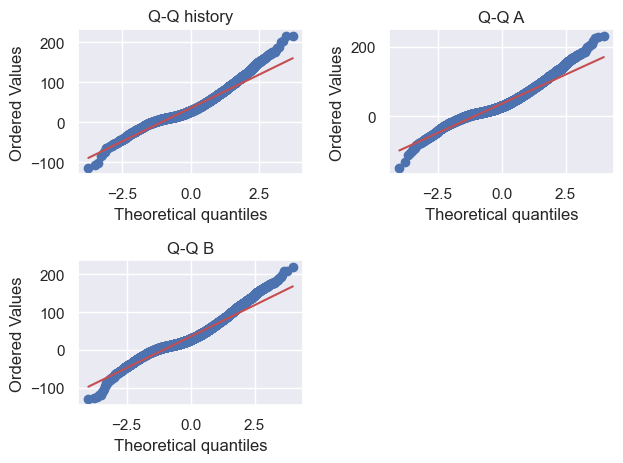

In [19]:
# Поскольку значений в выборках слишком много, воспользуемся визуальными методами, чтобы подтвердить тест Шапиро-Уилка
cols = {'history':h, 'A':a, 'B':b}
for idx, (name, col) in enumerate(cols.items()):
  plt.subplot(2, 2, idx + 1)
  sps.probplot(col, dist="norm", plot=plt)
  plt.title(f'Q-Q {name}')

plt.tight_layout()
plt.show()

# Отсутствие нормального распределения подтверждено

In [20]:
# Проверяем различия между группами с помощью теста Крускала-Уоллиса

kr_statistic, kr_p_value = sps.kruskal(h, a, b)
print(f'Статистик {kr_statistic}, p_value {kr_p_value}')

if kr_p_value > alpha: # Интерпретируем
    print('Одинаковые распределения (не отвергаем H0), значимой разницы не обнаружено')
else:
    print('Средние отличаются')

# Статистик 5.035198479628889, p_value 0.0806530030261136
# Одинаковые распределения (не отвергаем H0), значимой разницы не обнаружено
# Время выполнения:  0.030722618103027344

Статистик 5.035198479628889, p_value 0.0806530030261136
Одинаковые распределения (не отвергаем H0), значимой разницы не обнаружено


In [21]:
print(f'Дисперсия history: {np.var(h)}')
print(f'Дисперсия A: {np.var(a)}')
print(f'Дисперсия B: {np.var(b)}')

Дисперсия history: 1179.8911066373018
Дисперсия A: 1184.441556272468
Дисперсия B: 1165.6034807769


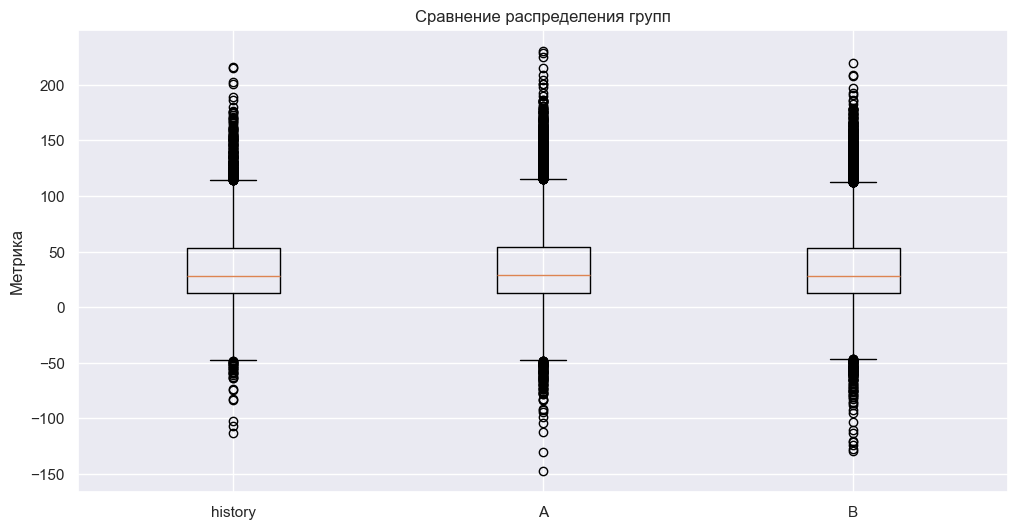

In [22]:
plt.figure(figsize=(12, 6))
groups_graph = [h, a, b]
plt.boxplot(groups_graph, tick_labels=['history', 'A', 'B'])
plt.title('Сравнение распределения групп')
plt.ylabel('Метрика')
plt.show()

<div class="alert alert-info">

<b>Задание:</b>    
    
Найти различие между группами, увеличив чувствительность тестов тремя способами поочередно:
* Бутстрап
* Стратификация
* CUPED
    
Вспомогательная статья Валерия Бабушкина про стратификацию и CUPED:

* habr.com/ru/company/yandex/blog/497804/

## Mетод бутстрэп

In [24]:
h = data[data['group'] == 'history']['metrica']
a = data[data['group'] == 'A']['metrica']
b = data[data['group'] == 'B']['metrica']
len(h), len(a), len(b)

(7143, 21427, 21430)

In [25]:
# Количество бутстрап-выборок
n_iterations = 5000
# Размер каждой бутстрап-выборки
sample_size_h = len(h)
sample_size_a = len(a)
sample_size_b = len(b)

# Функция для бутстрапирования
def bootstrap_sample(data, n_iterations):
    return [np.random.choice(data, size=len(data), replace=True) for i in tqdm(range(n_iterations))]

# Генерация бутстрап-выборок
bootstrap_h = bootstrap_sample(h, n_iterations)
bootstrap_a = bootstrap_sample(a, n_iterations)
bootstrap_b = bootstrap_sample(b, n_iterations)

NameError: name 'tqdm' is not defined

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3017.11it/s]
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 943.44it/s]
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 962.10it/s]

In [27]:
def get_boot_means(boot_lists):
    boot_means = []
    for boot_list in boot_lists:
        boot_means.append(boot_list.mean())
    return boot_means

h_boot_means = get_boot_means(bootstrap_h)
a_boot_means = get_boot_means(bootstrap_a)
b_boot_means = get_boot_means(bootstrap_b)

NameError: name 'bootstrap_h' is not defined

In [28]:
print(sps.shapiro(h_boot_means))
print(sps.shapiro(a_boot_means))
print(sps.shapiro(b_boot_means))

NameError: name 'h_boot_means' is not defined

ShapiroResult(statistic=0.9997149329862959, pvalue=0.7509979482873954)
ShapiroResult(statistic=0.9997486006868582, pvalue=0.8431300356605241)
ShapiroResult(statistic=0.9996311093616277, pvalue=0.5005042155982256)

In [29]:
cols = {'history':h_boot_means, 'A':a_boot_means, 'B':b_boot_means}
for idx, (name, col) in enumerate(cols.items()):
  plt.subplot(2, 2, idx + 1)
  sps.probplot(col, dist="norm", plot=plt)
  plt.title(f'Q-Q {name}')

plt.tight_layout()
plt.show()

# Нормальное распределение подтверждено

NameError: name 'h_boot_means' is not defined

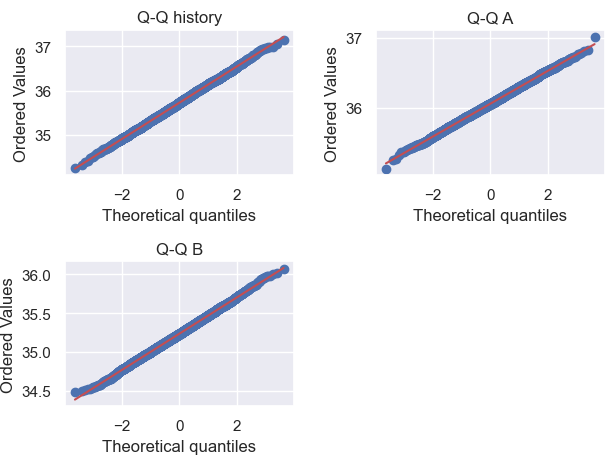

In [30]:
print(len(h_boot_means), len(a_boot_means), len(b_boot_means))
# (5000, 5000, 5000)

h_mean_mean = np.mean(h_boot_means)             # 35.72384823970872
print(h_mean_mean)
a_mean_mean = np.mean(a_boot_means)             # 36.059532465446864
print(a_mean_mean)
b_mean_mean = np.mean(b_boot_means)             # 35.232295580207214
print(b_mean_mean)

print(f'Дисперсия бутстрэп-history: {np.var(h_boot_means)}')
print(f'Дисперсия бутстрэп-A: {np.var(a_boot_means)}')
print(f'Дисперсия бутстрэп-B: {np.var(b_boot_means)}')

NameError: name 'h_boot_means' is not defined

5000 5000 5000
35.72384823970872
36.059532465446864
35.232295580207214
Дисперсия бутстрэп-history: 0.16592237399102797
Дисперсия бутстрэп-A: 0.05477322912912082
Дисперсия бутстрэп-B: 0.0544531441481643

In [31]:
# Распределение нормальное, размеры выборок одинаковые, однородность не имеет значения, можем воспользоваться критерием Фишера
print(sps.f_oneway(h_boot_means, a_boot_means, b_boot_means))
# F_onewayResult(statistic=9435.087978109508, pvalue=0.0)

NameError: name 'h_boot_means' is not defined

In [32]:
# Post hoc test Tukey

df = pd.DataFrame({
    'means': np.concatenate((h_boot_means, a_boot_means, b_boot_means)),
    'group': np.repeat(['history', 'A', 'B'], repeats=len(h_boot_means))
})
tukey = pairwise_tukeyhsd(df['means'],
                          df['group'],
                          alpha=0.05)
print(tukey)

NameError: name 'h_boot_means' is not defined

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
====================================================
group1  group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
     A       B  -0.8272   0.0 -0.8414  -0.813   True
     A history  -0.3357   0.0 -0.3499 -0.3215   True
     B history   0.4916   0.0  0.4774  0.5058   True
----------------------------------------------------

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='group', y='means', data=df)
plt.title('Распределение метрики по группам')
plt.xlabel('')
plt.ylabel('Метрическая величина')
plt.show()

NameError: name 'df' is not defined

<Figure size 1200x600 with 0 Axes>

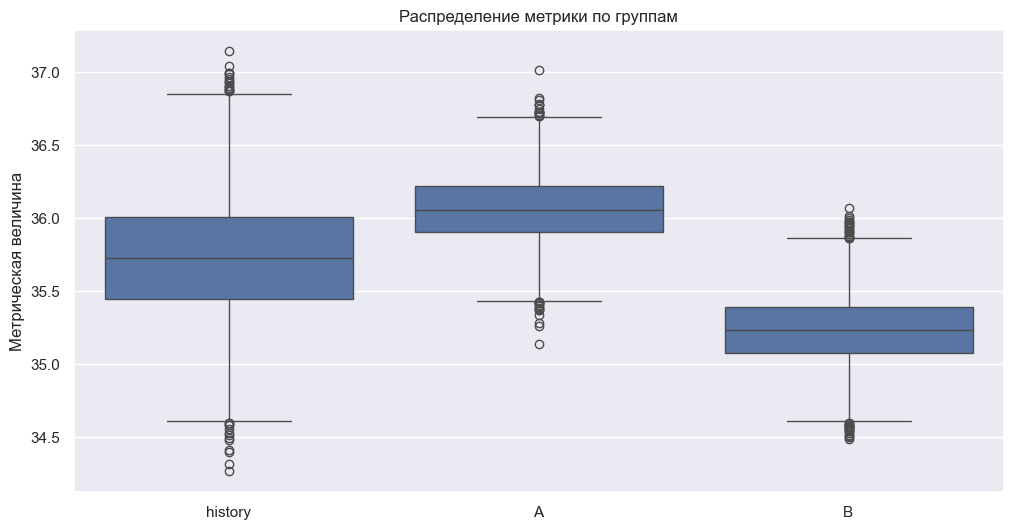

In [34]:
def conf_interval(data, alpha=0.95):
    lower = np.percentile(data, (1 - alpha) / 2 * 100)
    upper = np.percentile(data, (1 + alpha) / 2 * 100)
    return lower, upper

# Рассчитываем доверительные интервалы для каждой группы
ci_h = conf_interval(h_boot_means)
ci_a = conf_interval(a_boot_means)
ci_b = conf_interval(b_boot_means)

print(f'Доверительный интервал для группы history: {ci_h}')
print(f'Доверительный интервал для группы A: {ci_a}')
print(f'Доверительный интервал для группы B: {ci_b}')

NameError: name 'h_boot_means' is not defined

Доверительный интервал для группы history: (34.933526917208084, 36.51181562189512)
Доверительный интервал для группы A: (35.60101388747343, 36.52009274968268)
Доверительный интервал для группы B: (34.77853503022187, 35.692169653783665)

In [35]:
plt.figure(figsize=(12, 8))
sns.histplot(h_boot_means, bins=20, kde=True, color="blue", label="Группа history", stat="density", alpha=0.6)
sns.histplot(a_boot_means, bins=20, kde=True, color="green", label="Группа А", stat="density", alpha=0.6)
sns.histplot(b_boot_means, bins=20, kde=True, color="orange", label="Группа B", stat="density", alpha=0.6)

# Добавляем вертикальные линии для средних значений
plt.axvline(h_mean_mean, color="blue", linestyle="--", label=f'Среднее бутстрэпа (history): {h_mean_mean:.2f}')
plt.axvline(a_mean_mean, color="green", linestyle="--", label=f'Среднее бутстрепа (a): {a_mean_mean:.2f}')
plt.axvline(b_mean_mean, color="orange", linestyle="--", label=f'Среднее бутстрепа (b): {b_mean_mean:.2f}')

# Доверительные интервалы
plt.axvline(ci_h[0], color="blue", linestyle=":", label=f'ДИ history: {ci_h[0]:.2f} - {ci_h[1]:.2f}')
plt.axvline(ci_h[1], color="blue", linestyle=":")
plt.axvline(ci_a[0], color="green", linestyle=":", label=f'ДИ группа A: {ci_a[0]:.2f} - {ci_a[1]:.2f}')
plt.axvline(ci_a[1], color="green", linestyle=":")
plt.axvline(ci_b[0], color="orange", linestyle=":", label=f'ДИ группа B: {ci_b[0]:.2f} - {ci_b[1]:.2f}')
plt.axvline(ci_b[1], color="orange", linestyle=":")

# Оформление графика
plt.title("Группы history, A и В: метод будстрэпа", fontsize=16)
plt.xlabel("Метрики", fontsize=12)
plt.ylabel("Плотность", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'h_boot_means' is not defined

<Figure size 1200x800 with 0 Axes>

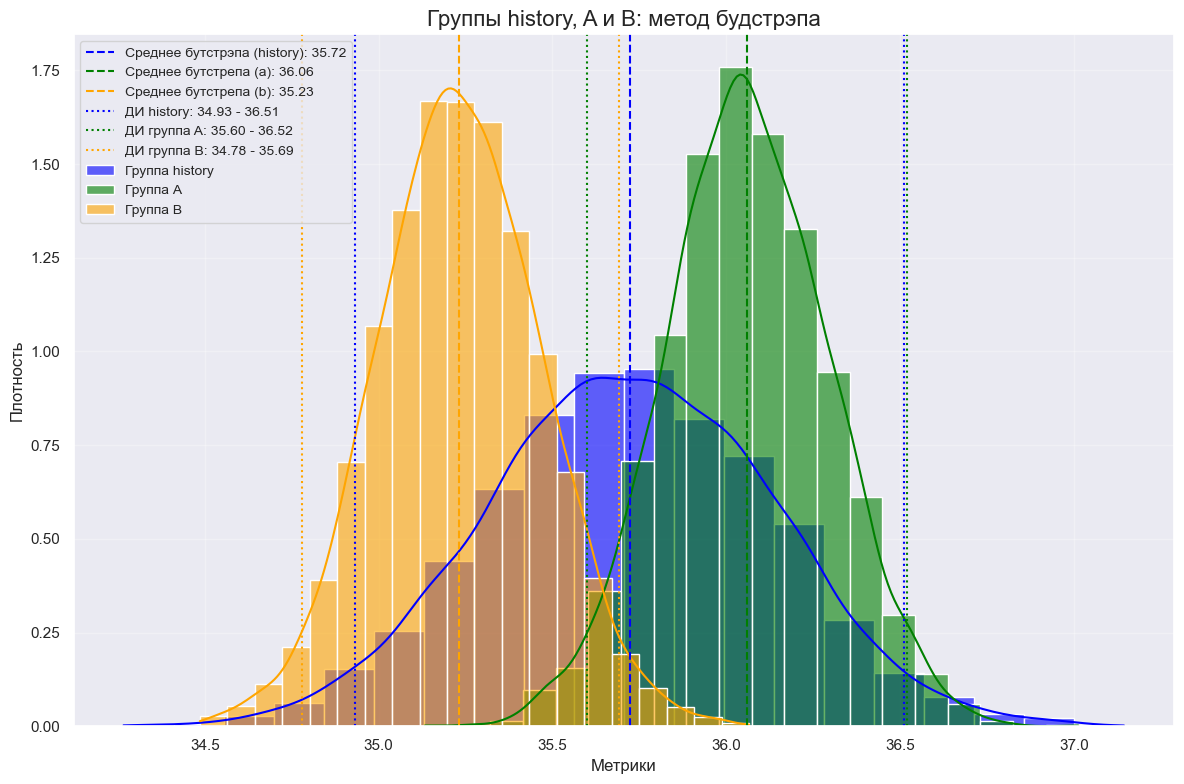

Интерпретация

Выборки сформированы бутстрэпированием. Был проведен ANOVA-анализ. С целью более наглядной оценки визуализировали данные.

    Средние значения:
        Группа "А" имеет более высокое среднее значение метрики (36.06), группа "В" имеет наименьшее среднее значение метрики (35.23), что говорит о необходимости каких-либо улучшений метрики для группы "В".
        Показатель группы "history" имеет среднее значение (35.73), она занимает промежуточное положение.
    ANOVA-анализ и тест Тьюки:
        Результат ANOVA (p_value < 0.05) указывает на наличие статистических значимых различиях между группами. Тест Тьюки указал, что различия наблюдаются между всеми группами.
    Доверительные интервалы:
        Группа 'history': ДИ от 34.96 до 36.51 (с 95%-вероятностью истинное значение для этой группы лежит в этом диапазоне).
        Группа 'A': ДИ от 35.60 до 36.51. Он частично перекрывается с интервалом 'history', что может указывать на схожесть этих групп.
        Группа 'B': ДИ от 34.79 до 35.68. Этот интервал не перекрывается с интервалами 'history' и 'A', что может свидетельствовать о значительных различиях между группой 'B' и остальными.
    Выводы:
        Группы 'A' и 'history' могут быть схожи по своим показателям, так как их доверительные интервалы пересекаются.
        Группа 'B' выделяется, поскольку её значения значительно ниже и не пересекаются с другими группами.
        Группа "A" превосходит другие группы по средним значениям.
        Группа "B" требует внимания, так как ее показатели ниже, что может вызвать необходимость улучшений.
        При это на графике видно, что показатели плотности значений группы "history" значительно ниже групп "А" и "В", а сама гистограмма и ДИ значительно шире, чем гистограммы и ДИ групп "А" и "В", что говорит о том, что оценка может быть менее точна, что для групп "А" и "В".

## Метод стратификации

In [36]:
print(data.columns)

Index(['group', 'metrica'], dtype='object')


In [37]:
print(data.index)

Index([11,  6,  4, 37, 18, 34,  9, 16, 43, 15,
       ...
       36, 14, 29,  9, 33, 47, 44, 49, 18, 41],
      dtype='int64', name='strata', length=50000)


In [38]:
# сбросим индексы, чтобы колонка strata стала "активной"
data.reset_index(inplace=True)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   strata   50000 non-null  int64  
 1   group    50000 non-null  object 
 2   metrica  50000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [40]:
# Посмотрим уникальные страты
data['strata'].unique()

array([11,  6,  4, 37, 18, 34,  9, 16, 43, 15, 20, 25,  0, 45, 23, 35, 21,
       46, 22, 17,  3, 41, 44, 12, 13, 24,  1, 26,  7, 30, 27,  2,  8, 40,
       33, 10, 36, 31, 32, 39, 19,  5, 28, 29, 38, 47, 42, 14, 49, 48])

In [41]:
# сформируем списки групп history, a и b внутри каждой страты
unique_strata = data['strata'].unique()

means_h = []
means_a = []
means_b = []

for strata in unique_strata:
    # Фильтруем данные по текущей страте
    stratum_data = data[data['strata'] == strata]

    strata_h = stratum_data[stratum_data['group'] == 'history']['metrica']
    means_h.append(strata_h.mean())
    strata_a = stratum_data[stratum_data['group'] == 'A']['metrica']
    means_a.append(strata_a.mean())
    strata_b = stratum_data[stratum_data['group'] == 'B']['metrica']
    means_b.append(strata_b.mean())


sps.shapiro(means_h)         # ShapiroResult(statistic=0.9598295811606185, pvalue=0.08744315930993932)
sps.shapiro(means_a)         # ShapiroResult(statistic=0.9549120781639007, pvalue=0.05447251159539939)
sps.shapiro(means_b)         # ShapiroResult(statistic=0.9607479711839708, pvalue=0.09554755723681695)

ShapiroResult(statistic=np.float64(0.9607479711839708), pvalue=np.float64(0.09554755723681695))

In [42]:
print(f' Дисперсия стратифицированной history: {np.var(means_h)}')
print(f' Дисперсия стратифицированной A: {np.var(means_a)}')
print(f' Дисперсия стратифицированной B: {np.var(means_b)}')

 Дисперсия стратифицированной history: 224.8355937645508
 Дисперсия стратифицированной A: 215.516960011768
 Дисперсия стратифицированной B: 202.9036515310619


In [43]:
# Тест Левене на гомоскедастичность

levene_stat, levene_p = sps.levene(means_h, means_a, means_b)
print(f'Статистики={levene_stat: .3f}, p={levene_p}')
if levene_p > alpha:
  print('Дисперсии равны (не отвергаем H0), можно применять ДА')
else:
  print('Дисперсии различаются (отвергаем H0), ДА применять нельзя')

Статистики= 0.125, p=0.8825868956030605
Дисперсии равны (не отвергаем H0), можно применять ДА


In [44]:
# Поскольку нормальность выборок подтверждена, равенство дисперсий присутствует,
# проводим тест Фишера для определения статистических различий между группами
sps.f_oneway(means_h, means_a, means_b)

# F_onewayResult(statistic=0.02835190692447564, pvalue=0.9720515508299934)
# p-value > alpha=0.05, Н0 об отсутствии статистически значимых различий между группами history, А и В не отвергаем

F_onewayResult(statistic=np.float64(0.02835190692447564), pvalue=np.float64(0.9720515508299934))

In [48]:
# Post hoc test Tukey

df = pd.DataFrame({
    'means': np.concatenate((means_h, means_a, means_b)),
    'groups': ['history'] * len(means_h) + ['A'] * len(means_a) + ['B'] * len(means_b)
})
tukey = pairwise_tukeyhsd(df['means'],
                          df['groups'],
                          alpha=0.05)
print(tukey)

NameError: name 'pairwise_tukeyhsd' is not defined

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
====================================================
group1  group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
     A       B  -0.5605 0.9804 -7.5649  6.444  False
     A history   0.0894 0.9995 -6.9151 7.0938  False
     B history   0.6498 0.9738 -6.3546 7.6543  False
----------------------------------------------------

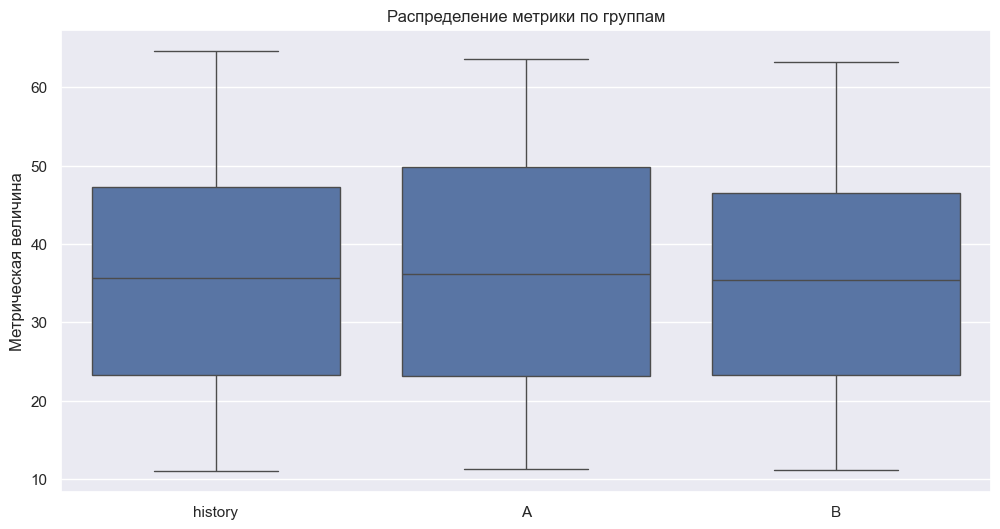

In [49]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='groups', y='means', data=df)
plt.title('Распределение метрики по группам')
plt.xlabel('')
plt.ylabel('Метрическая величина')
plt.show()

## Метод CUPED

In [50]:
# сбросим индексы, чтобы колонка strata стала "активной"
data.reset_index(inplace=True)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    50000 non-null  int64  
 1   strata   50000 non-null  int64  
 2   group    50000 non-null  object 
 3   metrica  50000 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.5+ MB


In [52]:
data.head()

,index,strata,group,metrica
0,0,11,history,42.631346
1,1,6,history,14.844453
2,2,4,history,2.362768
3,3,37,history,79.494017
4,4,18,history,-22.627788


In [53]:
# Добавляем ковариату в датасет
# (поскольку данных до теста у нас нет, в качестве ковариаты использую среднее значение метрики по страте)
mean_by_strata = data.groupby('strata')['metrica'].mean().reset_index()
mean_by_strata.rename(columns={'metrica': 'mean_metrica_by_strata'}, inplace=True)
data = pd.merge(data, mean_by_strata, on='strata', how='left')

data['centralized_metrica'] = data['metrica'] - data['mean_metrica_by_strata']

data.head()

,index,strata,group,metrica,mean_metrica_by_strata,centralized_metrica
0,0,11,history,42.631346,22.419721,20.211625
1,1,6,history,14.844453,16.955399,-2.110947
2,2,4,history,2.362768,15.617281,-13.254513
3,3,37,history,79.494017,48.759656,30.734360
4,4,18,history,-22.627788,28.821863,-51.449650


In [54]:
correlation = data['centralized_metrica'].corr(data['metrica'])
print(f'Коэффициент корреляции: {correlation}')
# centralized_metrica - и есть наша ковариата - независимый признак, который коррелирует с основной метрикой

Коэффициент корреляции: 0.9069150222423065


In [55]:
# Рассчитываем theta

covariance = np.cov(data['metrica'], data['centralized_metrica'])
variance = np.var(data['centralized_metrica'])

theta = covariance[0][1] / variance
print(theta)

1.0000200004000082


In [56]:
# Рассчитываем cuped-метрику

data['cuped_metrica'] = data['metrica'] - (data['centralized_metrica'] - np.mean(data['centralized_metrica'])) * theta
data.tail()

,index,strata,group,metrica,mean_metrica_by_strata,centralized_metrica,cuped_metrica
49995,49995,47,A,3.089373,59.203579,-56.114206,59.204701
49996,49996,44,A,54.028849,55.460096,-1.431247,55.460124
49997,49997,49,A,119.874609,60.982261,58.892348,60.981084
49998,49998,18,A,50.340589,28.821863,21.518726,28.821432
49999,49999,41,B,81.676537,49.544883,32.131654,49.544240


In [57]:
h_metrica = data[data['group'] == 'history']['metrica']
h_cuped_metrica = data[data['group'] == 'history']['cuped_metrica']
a_metrica = data[data['group'] == 'A']['metrica']
a_cuped_metrica = data[data['group'] == 'A']['cuped_metrica']
b_metrica = data[data['group'] == 'B']['metrica']
b_cuped_metrica = data[data['group'] == 'B']['cuped_metrica']

In [58]:
# Сравнение дисперсий
print(f'Группа history. Дисперсия до cuped: {h_metrica.var()}')
print(f'Группа history. Дисперсия после cuped: {h_cuped_metrica.var()}')

Группа history. Дисперсия до cuped: 1180.0563112167806
Группа history. Дисперсия после cuped: 203.33646614937007


In [59]:
# Сравнение дисперсий
print(f'Группа А. Дисперсия до cuped: {a_metrica.var()}')
print(f'Группа А. Дисперсия после cuped: {a_cuped_metrica.var()}')

Группа А. Дисперсия до cuped: 1184.4968368454295
Группа А. Дисперсия после cuped: 209.4192694027364


In [60]:
# Сравнение дисперсий
print(f'Группа В. Дисперсия до cuped: {b_metrica.var()}')
print(f'Группа В. Дисперсия после cuped: {b_cuped_metrica.var()}')

Группа В. Дисперсия до cuped: 1165.657874518128
Группа В. Дисперсия после cuped: 209.79712678310707


In [61]:
print(sps.shapiro(h_cuped_metrica))
print(sps.shapiro(a_cuped_metrica))
print(sps.shapiro(b_cuped_metrica))

ShapiroResult(statistic=np.float64(0.9554574071860911), pvalue=np.float64(4.033908491688887e-42))
ShapiroResult(statistic=np.float64(0.9524376743526896), pvalue=np.float64(1.185411557608479e-62))
ShapiroResult(statistic=np.float64(0.9514993157969417), pvalue=np.float64(4.8254905693276577e-63))


C:\Users\Hawk\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7143.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Hawk\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21427.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Hawk\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21430.
  res = hypotest_fun_out(*samples, **kwds)


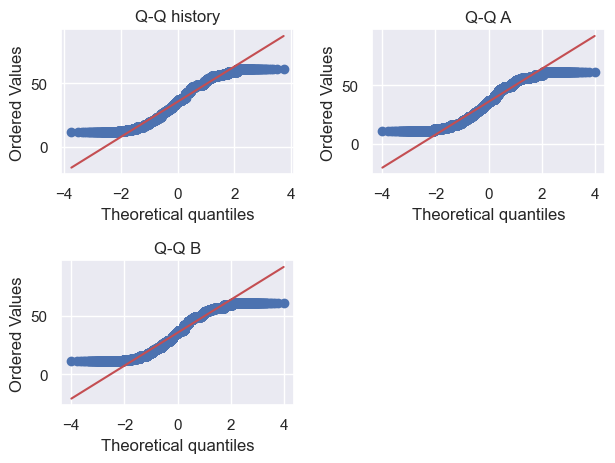

In [62]:
# Поскольку значений в выборках слишком много, воспользуемся визуальными методами, чтобы подтвердить тест Шапиро-Уилка
cols = {'history':h_cuped_metrica, 'A':a_cuped_metrica, 'B':b_cuped_metrica}
for idx, (name, col) in enumerate(cols.items()):
  plt.subplot(2, 2, idx + 1)
  sps.probplot(col, dist="norm", plot=plt)
  plt.title(f'Q-Q {name}')

plt.tight_layout()
plt.show()

# Отсутствие нормального распределения подтверждено

In [63]:
kr_statistic, kr_p_value = sps.kruskal(h, a, b)
print(f'Статистик {kr_statistic}, p_value {kr_p_value}')

if kr_p_value > alpha: # Интерпретируем
    print('Одинаковые распределения (не отвергаем H0), значимой разницы не обнаружено')
else:
    print('Средние отличаются')

Статистик 5.035198479628889, p_value 0.0806530030261136
Одинаковые распределения (не отвергаем H0), значимой разницы не обнаружено


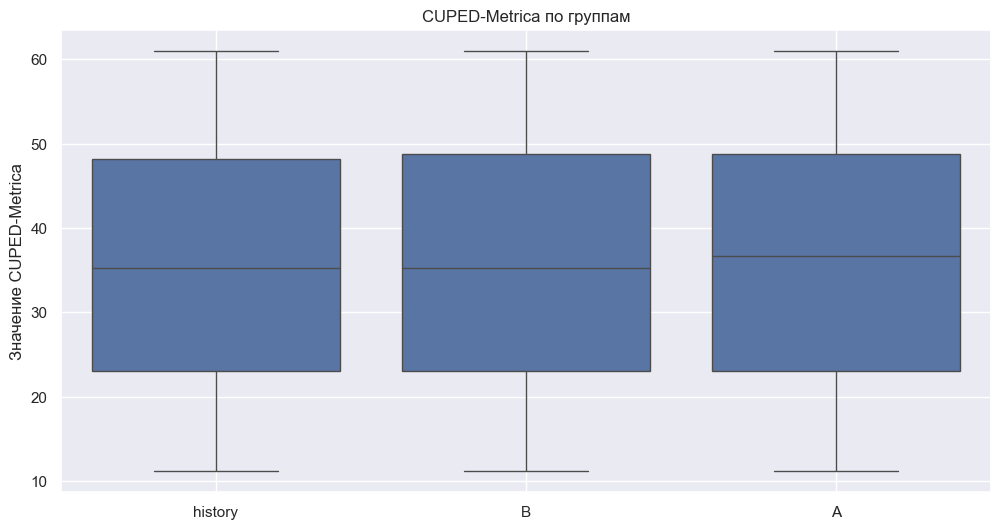

           count       mean        std        min        25%        50%  \
group                                                                     
A        21427.0  35.822784  14.471326  11.219243  23.041743  36.676887   
B        21430.0  35.554020  14.484375  11.219200  23.041550  35.302129   
history   7143.0  35.452635  14.259610  11.219256  23.041594  35.302187   

               75%        max  
group                          
A        48.760029  60.985306  
B        48.759672  60.985683  
history  48.119292  60.984661  


In [64]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='group', y='cuped_metrica', data=data)
plt.title('CUPED-Metrica по группам')
plt.xlabel('')
plt.ylabel('Значение CUPED-Metrica')
plt.grid(True)
plt.show()

# 2. Вычисляем основные статистики для strata по каждой группе
strata_stats = data.groupby('group')['cuped_metrica'].describe()
print(strata_stats)

In [65]:
sps.f_oneway(h_cuped_metrica, a_cuped_metrica, b_cuped_metrica)

F_onewayResult(statistic=np.float64(2.6693028870576647), pvalue=np.float64(0.06931039492781586))